In [ ]:
#Mounting google drive 
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
 import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/ECG Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# Based on ECG Classification notebook from Gregoire DC.
# Some terms are taken from harmanbhutani's fork of Gregoire DC's notebook.

/content/drive/MyDrive/ECG Dataset/ptbdb_normal.csv
/content/drive/MyDrive/ECG Dataset/mitbih_test.csv
/content/drive/MyDrive/ECG Dataset/ptbdb_abnormal.csv
/content/drive/MyDrive/ECG Dataset/mitbih_train.csv


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# import dataset
train_df = pd.read_csv("/content/drive/MyDrive/ECG Dataset/mitbih_train.csv", header = None)
test_df = pd.read_csv("/content/drive/MyDrive/ECG Dataset/mitbih_test.csv", header = None)

In [ ]:
# Value of each class
train_df[187].value_counts()

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64

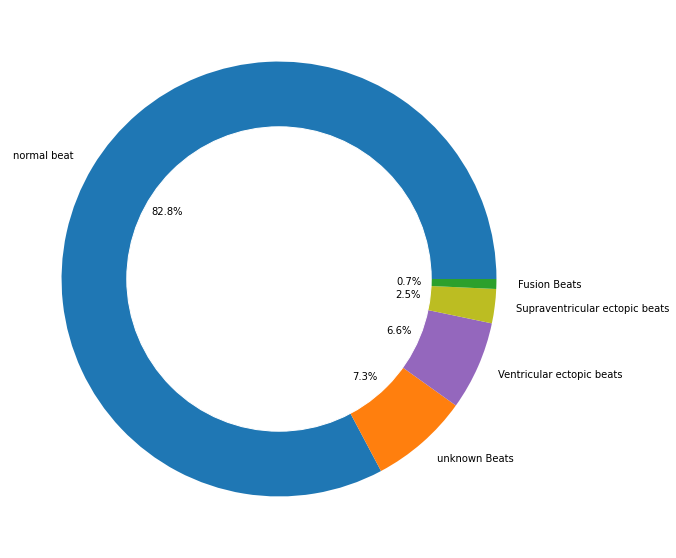

In [ ]:
# representation of classes % wise
per_class = train_df[187].value_counts()
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['normal beat','unknown Beats','Ventricular ectopic beats','Supraventricular ectopic beats','Fusion Beats'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# **Resampling for balacing the dataset**


In [ ]:
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

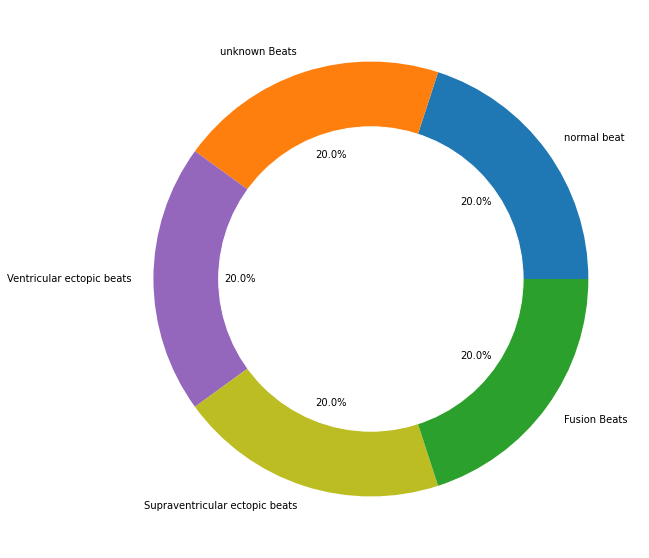

In [ ]:
# representation of classes % wise
per_class = train_df[187].value_counts()
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['normal beat','unknown Beats','Ventricular ectopic beats','Supraventricular ectopic beats','Fusion Beats'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# **Classes**

In [ ]:
# randomly sampling from each class
classes=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))

In [ ]:
# peek on classes
classes

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
14902,1.000000,0.782759,0.627586,0.475862,0.317241,0.303448,0.393103,0.420690,0.444828,0.451724,0.455172,0.451724,0.472414,0.475862,0.475862,0.489655,0.479310,0.506897,0.531034,0.517241,0.551724,0.572414,0.617241,0.620690,0.637931,0.665517,0.686207,0.696552,0.717241,0.720690,0.737931,0.724138,0.686207,0.634483,0.606897,0.568965,0.558621,0.520690,0.506897,0.503448,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
73355,0.908257,0.931193,0.311927,0.022936,0.105505,0.192661,0.165138,0.174312,0.284404,0.270642,0.243119,0.270642,0.316514,0.394495,0.417431,0.399083,0.389908,0.394495,0.399083,0.389908,0.394495,0.422018,0.412844,0.408257,0.399083,0.431193,0.444954,0.449541,0.454128,0.481651,0.509174,0.522936,0.555046,0.596330,0.614679,0.605505,0.628440,0.637615,0.642202,0.591743,...,0.311927,0.334862,0.357798,0.362385,0.376147,0.40367,0.40367,0.399083,0.417431,0.417431,0.37156,0.366972,0.357798,0.389908,0.385321,0.33945,0.311927,0.293578,0.307339,0.321101,0.321101,0.325688,0.321101,0.302752,0.302752,0.330275,0.33945,0.334862,0.357798,0.458716,0.706422,1.0,0.844037,0.169725,0.0,0.050459,0.114679,0.105505,0.165138,1.0
78967,0.865801,0.911255,0.854978,0.807359,0.800866,0.781385,0.794372,0.735931,0.502164,0.246753,0.145022,0.114719,0.093074,0.075758,0.064935,0.056277,0.056277,0.049784,0.036797,0.028139,0.034632,0.015152,0.019481,0.002165,0.004329,0.000000,0.010823,0.017316,0.030303,0.032468,0.060606,0.095238,0.134199,0.153680,0.199134,0.212121,0.238095,0.235931,0.233766,0.218615,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.0
80934,1.000000,0.983577,0.625912,0.332117,0.177007,0.155109,0.125912,0.118613,0.104015,0.104015,0.089416,0.102190,0.089416,0.098540,0.087591,0.087591,0.080292,0.080292,0.071168,0.076642,0.062044,0.076642,0.074818,0.082117,0.091241,0.114964,0.124088,0.151460,0.158759,0.180657,0.186131,0.197080,0.180657,0.186131,0.173358,0.171533,0.160584,0.167883,0.160584,0.167883,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,3.0
84492,1.000000,0.737662,0.415584,0.171429,0.103896,0.119481,0.122078,0.122078,0.122078,0.111688,0.106494,0.109091,0.085714,0.077922,0.070130,0.070130,0.064935,0.062338,0.051948,0.046753,0.028571,0.033766,0.012987,0.020779,0.010390,0.012987,0.002597,0.000000,0.007792,0.028571,0.020779,0.036364,0.049351,0.070130,0.075325,0.090909,0.109091,0.124675,0.137662,0.150649,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,4.0


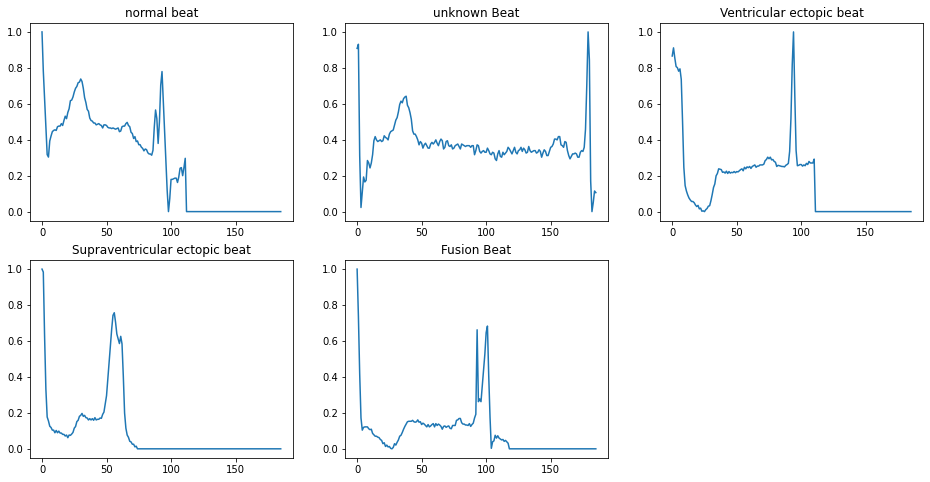

In [ ]:
# plotting classes ECG
plt.figure(figsize=(16,8))
# normal
plt.subplot(2, 3, 1)  
plt.plot(classes.iloc[0,:186])
plt.title('normal beat')
# unknown
plt.subplot(2, 3, 2)  
plt.plot(classes.iloc[1,:186])
plt.title('unknown Beat')
# veb
plt.subplot(2, 3, 3)  
plt.plot(classes.iloc[2,:186])
plt.title('Ventricular ectopic beat')
# seb
plt.subplot(2, 3, 4)  
plt.plot(classes.iloc[3,:186])
plt.title('Supraventricular ectopic beat')
# fusion
plt.subplot(2, 3, 5)  
plt.plot(classes.iloc[4,:186])
plt.title('Fusion Beat')
# show plot
plt.show()

# **Signal heatmap**

In [ ]:
def plot_hist(class_number,size,min_):
    # get the class data
    img=train_df.loc[train_df[187]==class_number].values
    # crop it
    img=img[:,min_:size]
    # creates a continous steam of data
    img_flatten=img.flatten()
    
    final1=np.arange(min_,size)
    for i in range (img.shape[0]-1):
        tempo1=np.arange(min_,size)
        final1=np.concatenate((final1, tempo1), axis=None)
    print(len(final1))
    print(len(img_flatten))
    plt.hist2d(final1,img_flatten, bins=(80,80),cmap=plt.cm.jet)
    plt.show()

1300000
1300000


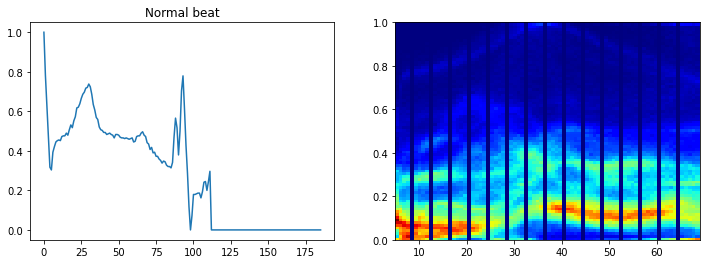

In [ ]:
# Normal Beat
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)  
plt.plot(classes.iloc[0,:186])
plt.title('Normal beat')
plt.subplot(1, 2, 2)  
plot_hist(0,70,5)

900000
900000


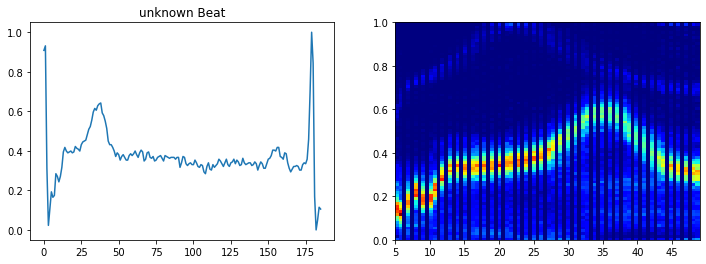

In [ ]:
# unknown
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(classes.iloc[1,:186])
plt.title('unknown Beat')
plt.subplot(1, 2, 2)  
plot_hist(1,50,5)

600000
600000


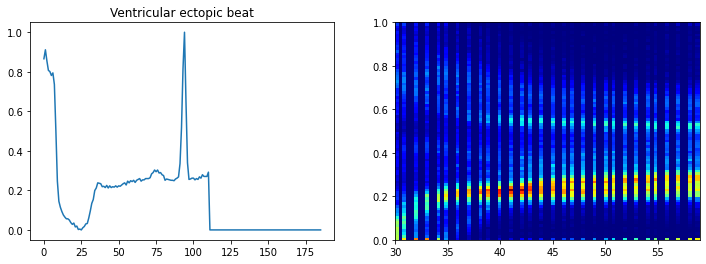

In [ ]:
# veb
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)  
plt.plot(classes.iloc[2,:186])
plt.title('Ventricular ectopic beat')
plt.subplot(1, 2, 2) 
plot_hist(2,60,30)

700000
700000


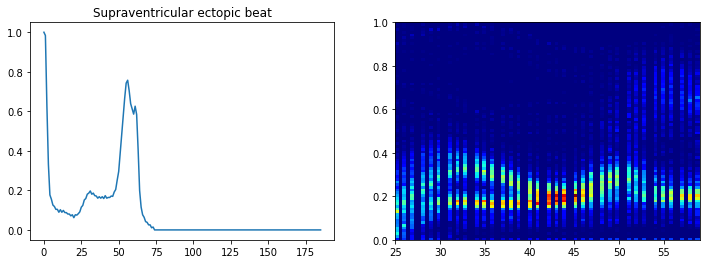

In [ ]:
# seb
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1) 
plt.plot(classes.iloc[3,:186])
plt.title('Supraventricular ectopic beat')
plt.subplot(1, 2, 2) 
plot_hist(3,60,25)

640000
640000


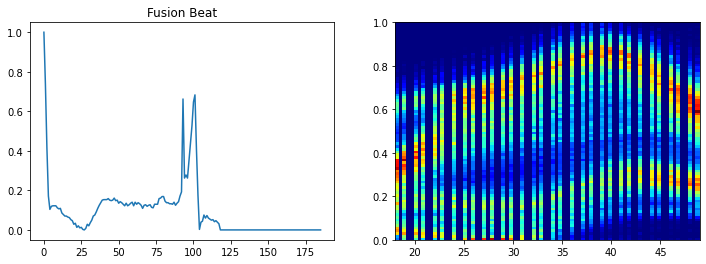

In [ ]:
# fusion
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)   
plt.plot(classes.iloc[4,:186])
plt.title('Fusion Beat')
plt.subplot(1, 2, 2) 
plot_hist(4,50,18)

# **Pretreat**

In [ ]:
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.05,186)
    return (signal+noise)

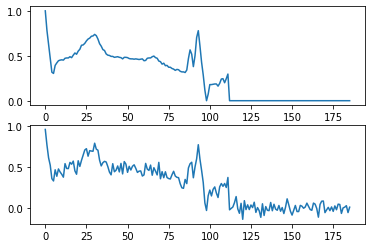

In [ ]:
tempo=classes.iloc[0,:186]
bruiter=add_gaussian_noise(tempo)

plt.subplot(2,1,1)
plt.plot(classes.iloc[0,:186])

plt.subplot(2,1,2)
plt.plot(bruiter)

plt.show()

In [ ]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [ ]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
#for i in range(len(X_train)):
#    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [ ]:
# Network
def network(X_train,y_train,X_test,y_test):
    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=5,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    return(model,history)

In [ ]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

In [ ]:
import tensorflow 
import keras

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LayerNormalization, BatchNormalization
#from tensorflow.keras.layers.LayerNormalization import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model,history=network(X_train,y_train,X_test,y_test)

Epoch 1/5
3125/3125 [==============================] - 103s 33ms/step - loss: 0.1845 - accuracy: 0.9339 - val_loss: 0.5317 - val_accuracy: 0.8031
Epoch 2/5
3125/3125 [==============================] - 102s 32ms/step - loss: 0.0734 - accuracy: 0.9748 - val_loss: 0.1182 - val_accuracy: 0.9636
Epoch 3/5
3125/3125 [==============================] - 102s 33ms/step - loss: 0.0514 - accuracy: 0.9830 - val_loss: 0.1382 - val_accuracy: 0.9561
Epoch 4/5
3125/3125 [==============================] - 103s 33ms/step - loss: 0.0367 - accuracy: 0.9880 - val_loss: 0.0980 - val_accuracy: 0.9740
Epoch 5/5
3125/3125 [==============================] - 103s 33ms/step - loss: 0.0291 - accuracy: 0.9908 - val_loss: 0.1361 - val_accuracy: 0.9662


Accuracy: 97.40%


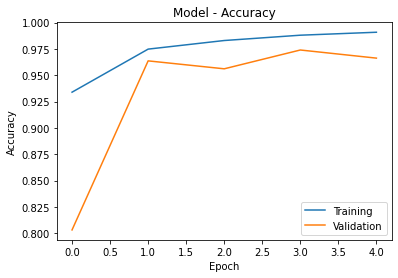

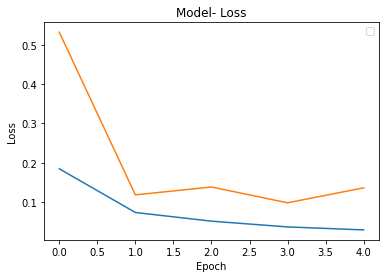

In [ ]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

Normalized confusion matrix


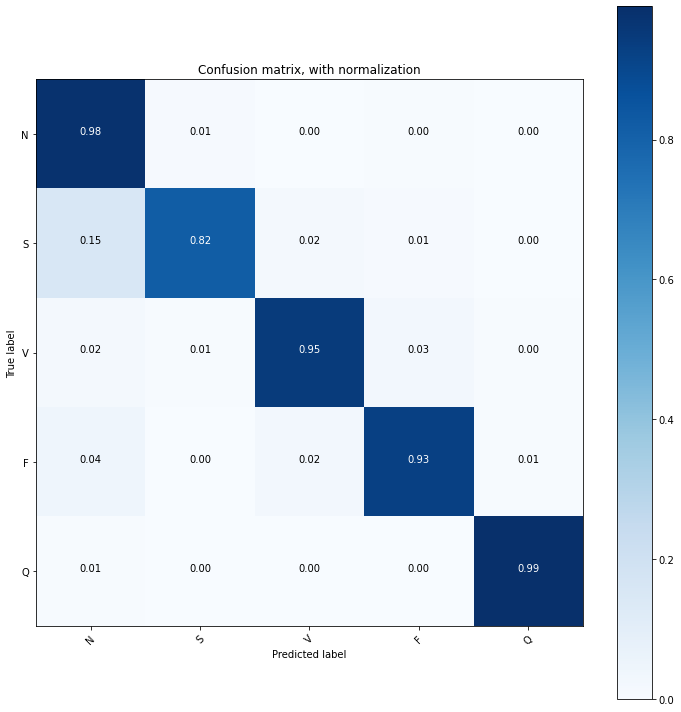

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()